<a href="https://colab.research.google.com/github/sebas0907/Python-projects/blob/master/1D_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import re
import sys
import random
from itertools import combinations
import numpy as np
np.set_printoptions(linewidth=10000)
import tensorflow as tf 
import tensorflow.keras as keras
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dropout, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LeakyReLU, Input, Reshape, Conv1DTranspose, Lambda, Embedding, LSTM, RepeatVector

In [1]:
#this line only in colab
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Loading and preprocessing the dataset

In [4]:
folder = os.getcwd()
#folder = os.getcwd()+'/gdrive/MyDrive/'

In [5]:
print(os.listdir(folder))

['.config', 'yahoo.txt', 'gdrive', 'sample_data']


In [10]:
file = 'yahoo.txt'

In [11]:
text = open(os.path.join(folder,file), errors='ignore', encoding='utf-8').read().lower()
text = text.split() #this makes sure to pick up the words
text = ' '.join(text) #this takes all the letters without the separators

In [12]:
print(text[-100:])

ra24 blu-fire leeonna7211 partys56 wegotmoney$ elro1014 a$$c0n wow777iee mustacchi 123321qq asdf1234


In [164]:
len(text.split())

443017

## Encoding the characters:

In [13]:
 #number of distinct characters:
chars = sorted(list(set(text))) #takes the whole characters as a set where no duplicates are allowed
vocab_size = len(chars)
print('Number of unique characters: ', vocab_size)

Number of unique characters:  73


In [14]:
#dictionary to match unique charaters with their index:
char_indices = {char:chars.index(char) for char in chars}

In [15]:
char_array = np.array(chars)
print(char_array)

[' ' '!' '#' '$' '%' '&' '(' ')' '*' '+' ',' '-' '.' '/' '0' '1' '2' '3'
 '4' '5' '6' '7' '8' '9' ':' ';' '=' '?' '@' '[' '\\' ']' '^' '_' '`' 'a'
 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's'
 't' 'u' 'v' 'w' 'x' 'y' 'z' '{' '|' '}' '~' '¦' '±' '´' 'ç' 'ü' 'č' 'ł'
 'ń']


In [16]:
chars_encoded = np.array([char_indices[ch] for ch in char_array], dtype='int32')
print(chars_encoded)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]


In [17]:
#dictionary that matches indices with their characters:
indices_char = {idx: chars[idx] for idx in chars_encoded}

In [18]:
#encoding of the whole text:
text_encoded = np.array([char_indices[ch] for ch in text], dtype='int32')

In [19]:
#search iteratively for different characters to be split e.g. @fl!pm0de = @ fl ! pm 0 de
seqs = ' '.join(re.split('(\d+)',text))
seqs = ' '.join(re.split('(\@)',seqs))
seqs = ' '.join(re.split('(\!)',seqs))
word_list = seqs.split()
print(word_list[:20])

['@', 'fl', '!', 'pm', '0', 'de', '@', 'pass', 'steveol', 'chotzi', 'lb', '2512', 'scotch', 'passwerd', 'flipmode', 'flipmode', 'alden', '2', 'salmon', 'tagoogle']


In [20]:
# Most popular sequences:
word_counter = {}
for word in word_list:
  if word in word_counter:
    word_counter[word] += 1
  else:
    word_counter[word] = 1
popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
top_30k = popular_words[:30000]
#random.shuffle(top_30k) #(optional)
print(top_30k[:30])

['1', '2', '123', '3', '4', '7', '0', '12', '5', '8', '!', '9', '6', '11', 'a', '@', '01', '13', '22', '23', '123456', '1234', 'm', '21', '10', 'b', '99', 'r', '69', 'd']


In [21]:
#encoding the characters of all the popular password sequences:
sequences = []
for word in top_30k:#text.split():
    sequences.append([char_indices[ch] for ch in word])

In [22]:
# padding sequences:
padded = sequence.pad_sequences(sequences)

In [23]:
max_len = len(padded[0])
print('lenght of sequences:', max_len)

lenght of sequences: 20


In [24]:
print('Number of sequences:',len(sequences))

Number of sequences: 30000


In [25]:
#finally the encoded passwords are given as an array of integers:
pass_encoded = np.array(padded, dtype='int32')
print(pass_encoded[-10:])

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 54 43 54]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 53 44 49 36 53 49 48]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 42 35 54 37 35 54]
 [ 0  0  0  0  0  0  0  0  0  0 53 45 35 54 39 49 52 38 43 39]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 36 43 41 36 55 36 36 35]
 [ 0  0  0  0  0  0  0  0 54 42 35 48 45 53 41 43 56 43 48 41]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 53 54 35 48 41 53]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15 18 22 16]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 38 43 53 50 46 35 59]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 15 14 14 17 17]]


## Definition of the training variables:

In [ ]:
#normalized sequences:
X = pass_encoded.astype('float32')

In [ ]:
print(X[0])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 44. 55. 48. 43.
 49. 52.]


In [ ]:
#training variables
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
print(X_train.shape, X_test.shape)

(24000, 20) (6000, 20)


In [ ]:
y_train, y_test = X_train.reshape((X_train.shape[0], X_train.shape[1],1)), X_test.reshape((X_test.shape[0], X_test.shape[1],1))

In [ ]:
print(y_train.shape, y_test.shape)

(24000, 20, 1) (6000, 20, 1)


In [ ]:
print(X_train[0])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 21. 16. 15.
 21. 15.]


##Model Training


In [110]:
K.clear_session()

In [111]:
#construction of the latent space from a Gaussian Distribution:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(tf.shape(z_log_var))
    return z_mean + epsilon*K.exp(z_log_var/2)

In [112]:
latent_size = 2
#latent_size=16 #is the optimum
encoder_inputs = Input(shape=(X_train.shape[1],1), name='Input')
x = keras.layers.LSTM(16, return_sequences=True)(encoder_inputs)
x = Conv1D(16, 3, activation='relu', padding='causal', dilation_rate=1)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1D(32, 3, activation='relu', padding='causal', dilation_rate=2, use_bias=False)(x) 
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1D(64, 3, activation='relu', padding='causal', dilation_rate=4, use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1D(128, 3, activation='relu', padding='causal', dilation_rate=8, use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1D(256, 3, activation='relu', padding='causal', dilation_rate=16, use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Flatten()(x)
x = Dense(2*latent_size, use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
z_mean = Dense(latent_size, name='Mean', use_bias=False)(x)
z_log_var = Dense(latent_size, name='Variance', use_bias=False)(x)
z = Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(inputs=encoder_inputs, outputs=z, name='Encoder')
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 18, 1)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 18, 16)       1152        Input[0][0]                      
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 18, 16)       784         lstm[0][0]                       
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 18, 16)       0           conv1d[0][0]                     
____________________________________________________________________________________________

In [113]:
decoder_inputs = Input(shape=(latent_size,), name='Input')
x = Dense(X_train.shape[1]*2*128)(decoder_inputs)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Reshape((X_train.shape[1],2*128))(x)
x = Conv1DTranspose(filters=256, kernel_size=3, padding='same', use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1DTranspose(filters=128, kernel_size=3, padding='same', use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1DTranspose(filters=64, kernel_size=3, padding='same', use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1DTranspose(filters=32, kernel_size=3, padding='same', use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = Conv1DTranspose(filters=16, kernel_size=3, padding='same', use_bias=False)(x)
x = LeakyReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LSTM(16, return_sequences=True)(x)
x = keras.layers.TimeDistributed(Dense(1), name='Output')(x) 
decoder = keras.Model(inputs=decoder_inputs, outputs=x, name='Decoder')
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4608)              13824     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4608)              0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 4608)              18432     
_________________________________________________________________
reshape (Reshape)            (None, 18, 256)           0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 18, 256)           196608    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 18, 256)           0   

In [114]:
codings=encoder(encoder_inputs)
reconstructions=decoder(codings)
#Bottleneck of size 16 with input lenght 20
vae=keras.Model(inputs=encoder_inputs, outputs=reconstructions, name='VAE')
vae.summary()

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 18, 1)]           0         
_________________________________________________________________
Encoder (Functional)         (None, 2)                 152944    
_________________________________________________________________
Decoder (Functional)         (None, 18, 1)             363537    
Total params: 516,481
Trainable params: 505,273
Non-trainable params: 11,208
_________________________________________________________________


In [115]:
#Cost annealing strategy:
class AnnealingCallback(keras.callbacks.Callback):
    def __init__(self, weight = tf.keras.backend.variable(0.0), start=0, time=100):
        self.weight = weight
        self.start = start
        self.time = time
    def on_epoch_end (self, epoch, logs={}):
        if epoch > self.start :
            new_weight = min(tf.keras.backend.get_value(self.weight) + (1./ self.time), 1.)
            tf.keras.backend.set_value(self.weight, new_weight)
        print("Current beta: " + str(tf.keras.backend.get_value(self.weight)))

AC = AnnealingCallback()
beta = AC.weight

In [116]:
#KL-divergence:
vae_loss = -0.5*beta*K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=-1)

In [117]:
#Mean-Squared and Mean-Absolute Errors:
MAE = tf.squeeze(K.sum(abs(vae.input-vae.output), axis=1),1)
MSE=tf.squeeze(K.sum(K.square(vae.input-vae.output),axis=1),1)

In [118]:
#ELBO = Reconstruction loss + KL-divergence:
#ELBO=K.mean(vae_loss+X_train.shape[1]*MSE)
ELBO=K.mean(vae_loss+MSE)

In [119]:
vae.add_metric(ELBO, name='ELBO')

In [120]:
#opt = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
opt = keras.optimizers.Adam(clipnorm=0.1)
#loss = keras.losses.MeanAbsoluteError()
loss = keras.losses.MeanSquaredError()

In [121]:
#Best reconstruction loss (MSE) so far is achieved when the KL divergence is divided by 2000 and a GRU/LSTM layer is included.
#The optimization is Adam with default learning rate 
vae.add_loss(K.mean(vae_loss)) #--> KL_loss/original_dims *10
#vae.add_metric(vae_loss, name='KL')

In [122]:
vae.compile(loss=loss, optimizer=opt)

In [123]:
#Callbacks list (Tensorboard can be included too!):
#log_dir = "logs/fit/"
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_ELBO', factor=0.1, patience=5)
ES = tf.keras.callbacks.EarlyStopping(monitor='ELBO', patience=4)
#TB = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)
callbacks_list = [LR, ES, AC]

In [ ]:
#Train for approximately 150 epochs for best results
#the bigger the dataset the better the results
history = vae.fit(y_train, y_train, validation_data=(y_test, y_test), epochs=150, shuffle=True, batch_size=256, callbacks=callbacks_list)

Epoch 1/150
94/94 [==============================] - 13s 50ms/step - loss: 453.5761 - ELBO: 8478.3076 - val_loss: 396.3964 - val_ELBO: 7928.9043
Current beta is 0.0
Epoch 2/150
94/94 [==============================] - 3s 35ms/step - loss: 378.6448 - ELBO: 7410.3657 - val_loss: 383.8811 - val_ELBO: 7679.2251
Current beta is 0.01
Epoch 3/150
94/94 [==============================] - 3s 35ms/step - loss: 345.6195 - ELBO: 6783.3569 - val_loss: 323.2213 - val_ELBO: 6465.0391
Current beta is 0.02
Epoch 4/150
94/94 [==============================] - 3s 36ms/step - loss: 315.8923 - ELBO: 6212.0532 - val_loss: 295.5254 - val_ELBO: 5911.1348
Current beta is 0.03
Epoch 5/150
94/94 [==============================] - 3s 36ms/step - loss: 289.4270 - ELBO: 5670.4175 - val_loss: 269.2894 - val_ELBO: 5386.3667
Current beta is 0.04
Epoch 6/150
94/94 [==============================] - 3s 37ms/step - loss: 263.8263 - ELBO: 5157.6118 - val_loss: 244.5314 - val_ELBO: 4891.1548
Current beta is 0.05
Epoch 7/15

In [ ]:
#From here one can select the optimal learning rate:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-1, 0, 600])

In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
from keras.utils import plot_model
plot_model(model=encoder, show_shapes=True, show_layer_names=False,to_file='Encoder.png')

In [ ]:
score = vae.evaluate(y_test,y_test)

188/188 [==============================] - 1s 7ms/step - loss: 0.0378 - ELBO: 0.7554


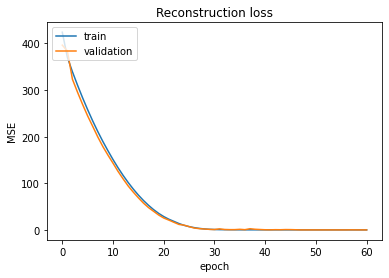

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Reconstruction loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

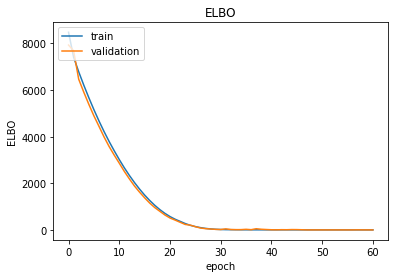

In [ ]:
plt.plot(history.history['ELBO'])
plt.plot(history.history['val_ELBO'])
plt.title('ELBO')
plt.ylabel('ELBO')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
example = tf.random.normal(shape=(10,latent_size))

In [ ]:
#preds = sc.inverse_transform(tf.squeeze(vae.predict(ys_test)).numpy()).astype('int32')
preds = np.round(tf.squeeze(vae.predict(y_test)).numpy()).astype('int32')
print(preds[:10])

[[ 0  0  0  0  0  0  0  0  0  0  0 40 49 52 47 59 45 43 38 53]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 46 55 56 43 53]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 45]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18 14 18]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 53 48 49 49 41 43 39]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 22 20 23 20]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 23 21 21]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 19 19 17 18]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 37 35 54 46 49 55 39 52]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 21 16 21 15 22 18 20]]


In [ ]:
print(X_test[:10].astype('int32'))

[[ 0  0  0  0  0  0  0  0  0  0  0 40 49 52 47 59 45 43 38 53]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 46 55 56 43 53]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 45]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18 14 18]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 53 48 49 49 41 43 39]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 22 20 23 20]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 23 21 21]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 19 19 17 18]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 37 35 54 46 49 56 39 52]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 21 16 21 15 23 18 20]]


In [ ]:
print(np.abs(tf.squeeze(decoder(example)).numpy()).astype('int32'))

[[ 2  3  7 13 23 37 39 42 38 38 40 34 35 44 42 45 45 42 43 47]
 [ 3  6 14 26 35 37 38 36 39 52 34 41 38 46 43 49 41 44 44 43]
 [ 2  3  7 11 19 27 28 28 25 24 28 30 30 34 35 38 35 41 43 36]
 [ 1  2  3  5  7  6  3  1  0  0  0  0  0  2  9  4  2 41 44 45]
 [ 1  1  2  2  2  1  1  1  1  2  0 34 39 49 49 52 44 47 50 47]
 [ 0  0  0  0  1  2  3  2  2 12 12 35 39 49 45 52 40 47 48 48]
 [ 1  1  2  2  2  2  5 31 39 39 43 44 36 29 48 50 50 51 48 46]
 [ 0  0  0  0  0  0  0  0  1  0 13  9  1 37 48 44 50 46 48 45]
 [ 1  2  3  7 13 19 29 27 27 32 28 40 37 25 46 44 42 44 49 44]
 [ 2  3  7 13 23 30 34 33 30 35 31 33 33 33 43 44 38 46 45 41]]


In [ ]:
def samples2text(samples):
  result = tf.squeeze(decoder(samples))
  result_encoded=np.abs(result.numpy()).astype('int32')

  passwords = []
  for word in result_encoded:
    passwords.append([indices_char[idx] for idx in word])
    passworten = [''.join(code).strip() for code in passwords]

  return passworten

In [ ]:
def seqs2text(arr):

  passwords = []
  for word in arr:
    passwords.append([indices_char[idx] for idx in word])
    passworten = [''.join(code).strip() for code in passwords]

  return passworten

In [ ]:
print(samples2text(example))

['#$)/9cehddf`ajhkkhim', '$(0=acdber`gdliogjji', '#$)-5?@@;:@\\\\`adagib', '!#$&)($!     #+%#gjk', '!!###!!!!# `eoorjmpm', '!#$##..aeokrfmnn', '!!####&]eeijb[nppqnl', '! /+!cnjplnk', '!#$)/5[??^@fc;ljhjoj', '#$)/9\\`_\\a]___ijdlkg']


In [ ]:
vae.save('1d_vae.h5',overwrite=True)

In [ ]:
print(np.abs(preds[:10]))

[[ 0  0  0  0  0  0  0  0  0  0  0 40 49 52 47 59 45 43 38 53]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 46 55 56 43 53]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 45]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18 14 18]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 53 48 49 49 41 43 39]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 22 20 23 20]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 23 21 21]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 19 19 17 18]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 37 35 54 46 49 55 39 52]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 21 16 21 15 22 18 20]]


In [ ]:
print(X_test[:10].astype('int32'))

[[ 0  0  0  0  0  0  0  0  0  0  0 40 49 52 47 59 45 43 38 53]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 46 55 56 43 53]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 45]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18 14 18]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 53 48 49 49 41 43 39]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 22 20 23 20]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 23 21 21]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 19 19 17 18]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 37 35 54 46 49 56 39 52]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 21 16 21 15 23 18 20]]


In [ ]:
seqs2text(np.abs(preds[-30:]))

['linked',
 '#xinn',
 'gunbound',
 'mamie',
 'heyhey',
 'reeree',
 'dayday',
 'chinna',
 'sabbath',
 'tunes',
 'court',
 '!vb',
 'josi',
 'joeblow',
 'mara',
 'richa',
 '2322',
 'bso',
 'montero',
 '9600',
 '185',
 '1395',
 'eer',
 'eph',
 '#wakiya',
 'hms',
 'swati',
 '666899',
 'life',
 'lilica']

In [ ]:
seqs2text(X_test[-30:])

['linked',
 'zinn',
 'gunbound',
 'mamie',
 'heyhey',
 'reeree',
 'dayday',
 'chinna',
 'sabbath',
 'tunes',
 'court',
 'vb',
 'josi',
 'joeblow',
 'mara',
 'richa',
 '2322',
 'aso',
 'montero',
 '9600',
 '185',
 '1395',
 'eer',
 'eph',
 'zakiya',
 'hms',
 'swati',
 '666999',
 'life',
 'lilica']

#Generating sequences at word level:
Instead of a character based approach, here we take all of the popular sequences as plain text and divide it into equal length chunks. Thus the vocabulary here is composed of the 30k different popular sequences (words).

In [129]:
#Plain text:
# Here we make sure to shuffle the entire set of popular sequences 
top_shuffle = top_30k.copy()
#top_shuffle = popular_words.copy()
#random.shuffle(top_shuffle)
plain_list = ' '.join(top_shuffle)

In [130]:
print(plain_list[:200])

1 2 123 3 4 7 0 12 5 8 ! 9 6 11 a @ 01 13 22 23 123456 1234 m 21 10 b 99 r 69 d n s 08 09 77 00 t 33 88 07 24 w password c p 19 14 j 17 k 55 e l 18 25 g h 15 06 16 2008 u 05 2009 20 27 x ac 03 q 44 12


In [131]:
print('lenght of the list:',len(plain_list))

lenght of the list: 198364


In [132]:
# split text into sentences:
def text_split(text, length):
    sentence = []
    last = 0.0
    while last < len(text):
        sentence.append(text[int(last):int(last + length)])
        last += length
    return sentence

In [133]:
# generate equal-length sentences
sentences = text_split(plain_list, 40)
print('Number of sentences: ',len(sentences))

Number of sentences:  4960


In [134]:
# fit the tokenizer on the sentences
t = Tokenizer(oov_token='<OOV>',filters=',"')
t.fit_on_texts(sentences)

In [135]:
# transforming the sentences to numerical tokens
sequences = t.texts_to_sequences(sentences)

In [136]:
len(sequences)

4960

In [137]:
print(sentences[0])
print(sequences[0])

1 2 123 3 4 7 0 12 5 8 ! 9 6 11 a @ 01 1
[11, 17, 581, 18, 22, 23, 19, 46, 24, 28, 1602, 31, 29, 96, 3, 1603, 213, 11]


In [138]:
#padding sequences
sequences_array = np.array(sequences, dtype=object)
padded_sequences = keras.preprocessing.sequence.pad_sequences(sequences_array)

In [139]:
vocab_size = len(t.word_index)
print('Size of vocabulary:',vocab_size)

Size of vocabulary: 28988


In [140]:
print('Lenght of sequences:',len(padded_sequences[100]))

Lenght of sequences: 18


In [141]:
print(padded_sequences[0])

[  11   17  581   18   22   23   19   46   24   28 1602   31   29   96    3 1603  213   11]


In [142]:
X = padded_sequences.astype('float32')
#training variables
X_train, X_test = train_test_split(X, test_size=0.2, shuffle=True, random_state=42)
y_train, y_test = X_train.reshape((X_train.shape[0], X_train.shape[1],1)), X_test.reshape((X_test.shape[0], X_test.shape[1],1))
#This is helpful for word-level encodings:
sc = MinMaxScaler() #Friendship ended with Standard Scaler now MinMaxScaler is my best friend
ys_train = sc.fit_transform(X_train).reshape((X_train.shape[0], X_train.shape[1],1))
ys_test = sc.transform(X_test).reshape((X_test.shape[0], X_test.shape[1],1))

In [144]:
history2 = vae.fit(ys_train, ys_train, validation_data=(ys_test, ys_test), epochs=100, shuffle=True, batch_size=256, callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 1s 76ms/step - loss: 0.0216 - ELBO: 0.3909 - val_loss: 0.0036 - val_ELBO: 0.0640
Current beta: 0.29000002
Epoch 2/100
16/16 [==============================] - 1s 37ms/step - loss: 0.0203 - ELBO: 0.3684 - val_loss: 0.0054 - val_ELBO: 0.0973
Current beta: 0.3
Epoch 3/100
16/16 [==============================] - 1s 36ms/step - loss: 0.0181 - ELBO: 0.3230 - val_loss: 0.0068 - val_ELBO: 0.1226
Current beta: 0.31
Epoch 4/100
16/16 [==============================] - 1s 34ms/step - loss: 0.0171 - ELBO: 0.3088 - val_loss: 0.0085 - val_ELBO: 0.1534
Current beta: 0.32
Epoch 5/100
16/16 [==============================] - 1s 36ms/step - loss: 0.0176 - ELBO: 0.3162 - val_loss: 0.0097 - val_ELBO: 0.1744
Current beta: 0.32999998
Epoch 6/100
16/16 [==============================] - 1s 35ms/step - loss: 0.0157 - ELBO: 0.2802 - val_loss: 0.0103 - val_ELBO: 0.1855
Current beta: 0.33999997
Epoch 7/100
16/16 [==============================] - 1s 37ms/step

In [145]:
# now we can generate some random samples: 
example = tf.random.normal(shape=(10,latent_size))
results = np.abs(sc.inverse_transform(tf.squeeze(decoder(example)).numpy()).astype('int32'))

In [146]:
rs = t.sequences_to_texts(results)

In [147]:
rs

['<OOV> <OOV> <OOV> <OOV> <OOV> s h d <OOV> an mi im et hellos zinger teetee squ myles',
 '<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> m r s ar my m hot promo colgate edison zachery rockie',
 '<OOV> <OOV> a <OOV> <OOV> a m c 5 59 che pr sur bigguy 571 1886 seagu dolores',
 '<OOV> <OOV> <OOV> <OOV> <OOV> c s 0 y ge jo no 197 myles 151515 saab beat lila',
 '<OOV> <OOV> s <OOV> <OOV> <OOV> r y h pa e y ey 2627 2056 jkljkl readme gohan',
 '<OOV> <OOV> <OOV> <OOV> <OOV> a <OOV> 2 y ie br 25 501 3778 blaster familia 1092 nonono',
 '<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> s e <OOV> rd ji mar - asdfjkl 935 hihihi hardrock puppies',
 '<OOV> <OOV> <OOV> <OOV> <OOV> s e 1 s k x ty tw mako liliana delete contest 695',
 '<OOV> <OOV> a <OOV> <OOV> <OOV> a s <OOV> si ya da 287 corn hallelu pres flyingbird gateway',
 '<OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> c <OOV> t fo god ol gymnast catnip 460 fishy rockie']

In [148]:
plain_results=' '.join(rs).replace('<OOV>','')

In [149]:
clean_results=np.array([w for w in plain_results.split() if len(w)>1])

In [150]:
print(clean_results)

['an' 'mi' 'im' 'et' 'hellos' 'zinger' 'teetee' 'squ' 'myles' 'ar' 'my' 'hot' 'promo' 'colgate' 'edison' 'zachery' 'rockie' '59' 'che' 'pr' 'sur' 'bigguy' '571' '1886' 'seagu' 'dolores' 'ge' 'jo' 'no' '197' 'myles' '151515' 'saab' 'beat' 'lila' 'pa' 'ey' '2627' '2056' 'jkljkl' 'readme' 'gohan' 'ie' 'br' '25' '501' '3778' 'blaster' 'familia' '1092' 'nonono' 'rd' 'ji' 'mar' 'asdfjkl' '935' 'hihihi' 'hardrock' 'puppies' 'ty' 'tw' 'mako' 'liliana' 'delete' 'contest' '695' 'si' 'ya' 'da' '287' 'corn' 'hallelu' 'pres' 'flyingbird' 'gateway' 'fo' 'god' 'ol' 'gymnast' 'catnip' '460' 'fishy' 'rockie']


In [151]:
contras=[]
for i in range(len(clean_results)):
  contras.append(''.join(list(np.random.choice(clean_results,2)))) 

In [152]:
contras

['asdfjklno',
 'imrockie',
 'eycolgate',
 'mylesie',
 'surdolores',
 'hotmar',
 '287hellos',
 'saab501',
 'flyingbirdey',
 '262759',
 'edisonpuppies',
 '10923778',
 '460rd',
 'hardrockzachery',
 'surim',
 'olhellos',
 'teetee501',
 'zinger571',
 'gatewayrockie',
 'cornfishy',
 'saabji',
 'seaguliliana',
 'teeteetw',
 'rockieda',
 'jkljklcatnip',
 'etnonono',
 'cheche',
 'yalila',
 'blasterjkljkl',
 'rockieie',
 'cheda',
 '571hellos',
 'presji',
 'mylespr',
 'myles2627',
 '571im',
 'catnipsur',
 'eyzachery',
 'edisonie',
 '287catnip',
 'colgatelila',
 '935gymnast',
 'etpuppies',
 'twliliana',
 'hallelumyles',
 'myleset',
 'rockieji',
 'gatewayedison',
 'catnipda',
 'halleluet',
 'hihihirockie',
 'bigguygohan',
 '695br',
 'imteetee',
 'catnipge',
 'asdfjklcorn',
 '935lila',
 'joan',
 '460jkljkl',
 'eyasdfjkl',
 'asdfjklya',
 'zacherybigguy',
 'fofamilia',
 'jipuppies',
 '1971886',
 'seagudelete',
 '59ey',
 'ancatnip',
 'hihihipr',
 'saaban',
 'blasteredison',
 'familiacorn',
 'familia205

In [153]:
#sampling a 2D latent space of size 10x10:
norm = tfp.distributions.Normal(0, 1)
grid_x = norm.quantile(np.linspace(0.05, 0.95, 20)).numpy()
grid_y = norm.quantile(np.linspace(0.05, 0.95, 20)).numpy()
#z_lat = np.array([ [xi,yi] for xi,yi in zip(grid_x,grid_y)])
z_lat = []
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z_lat.append([xi, yi])
z_lat = np.array(z_lat)

In [154]:
#generating a list of unique segments from the latent space vectors:
#to clean the list we must remove the oov characters and take only segments of more than one character
latent_space = np.abs(sc.inverse_transform(tf.squeeze(decoder(z_lat)).numpy()).astype('int32'))
latent_space_rs=t.sequences_to_texts(latent_space)
plain_latent_space =''.join(latent_space_rs).replace('<OOV>','')
clean_latent=np.array([w for w in plain_latent_space.split()])
unique_latent = list(np.unique(clean_latent))

In [155]:
print(sorted(unique_latent))

['$$w', '***', '0', '00', '0002', '001', '0011', '0012', '01', '010101', '0107', '0116', '0118', '0122', '0124', '0126', '0127', '013', '019', '0214', '0218', '0224', '023', '025', '0305', '0321', '0324', '0325', '0329', '040', '0413', '0418', '0425', '0428', '0435', '05', '051', '0510', '0511', '0519', '0526', '055', '06', '0608', '061', '0610', '0612', '0616', '0620', '0629', '066', '069', '07', '070', '0701', '0702', '0718', '0721', '08', '0818', '0831', '0835', '09', '0917', '0919', '0920', '1', '10', '100', '102', '1064', '1065', '1069', '1088', '1092', '1093', '1098', '11', '111111', '1118', '112', '1122', '112358', '113', '1141', '1143', '1150', '1154', '1157', '1165', '1172', '1175', '1179', '1180', '1187', '1195', '1198', '12', '121685', '123123', '1232', '123454321', '123456', '123456789', '123465', '123654789', '1247', '1255', '1277', '1287', '1295', '13', '1305', '1311', '131106', '1312', '1318', '1339', '1346', '1357', '135790', '1375', '1401', '1405', '1411', '1431', '145

In [156]:
pairs=list(combinations(unique_latent,2))
pairs_list=[''.join(pair) for pair in pairs]

In [157]:
print('Number of unique segments: ',len(unique_latent))
print('Number of all posible pairs of unique segments: ',len(pairs_list))

Number of unique segments:  2301
Number of all posible pairs of unique segments:  2646150


In [158]:
complete_list = unique_latent+pairs_list

In [163]:
#let's try to find words!
try:
  ind=complete_list.index(str(input()))
  print(complete_list[ind:ind+100])
except:
  print(random.sample(complete_list,100))

dog
['dog', 'dogboy', 'dogg', 'doggies', 'dogma', 'doit', 'doll', 'dollface', 'dolores', 'dominick', 'dondon', 'done', 'dorian', 'dover', 'dre', 'drea', 'droopy', 'ds', 'ducati', 'duchess', 'ducks', 'dunbar', 'dune', 'dupont', 'durango', 'dust', 'duster', 'dwade', 'dy', 'e', 'ea', 'eag', 'eanna', 'easter', 'eatshit', 'ecko', 'ed', 'edc', 'edd', 'edith', 'eduardo', 'ee', 'eefrog', 'ei', 'ejhej', 'ejs', 'ekim', 'el', 'elajg', 'elder', 'elisabeth', 'elise', 'elives', 'ell', 'elle', 'ello', 'elohim', 'elvisp', 'email', 'ember', 'emc', 'emilee', 'emilie', 'emm', 'emmy', 'emo', 'emy', 'en', 'enchanted', 'encore', 'end', 'ennings', 'enoch', 'enport', 'ent', 'enter', 'enupnow', 'er', 'erbert', 'ergie', 'erick', 'ericka', 'erie', 'ernest', 'ernie', 'ers', 'es', 'espana', 'et', 'ethel', 'etnies', 'eu', 'eused', 'evolution', 'ewok', 'exc', 'excellence', 'excellent', 'ey', 'eyes']


In [ ]:
# Amazing! 
# out of only 100 vectors from the latent space we got more than 300k different words!